# Projet 2 : Analyse des données de systèmes éducatifs

## 0. Importations des modules et des données

In [5]:
## IMPORTATIONS
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline
#% matplotlib notebook
# graphes interactifs
import re
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
from IPython.display import Image
#import scipy.stats as st
#import statsmodels.api as sm
#from sklearn.datasets import load_iris
#iris_df_ori = load_iris()

####     A ESSAYER      #######################################################
# GRAPHES INTERACTIFS


# POUR LES GRAPHIQUES
# % matplotlib inline 
# plt.rcParams['figure.figsize'] = [9.5, 6] # ajuster la taille

# POUR DESACTIVER LA TOOLBOX GRAPHES TOP GRANDS
# %%javascript
# IPython.OutputArea.prototype._should_scroll = function(lines) {
#     return false;
# }

In [50]:
## FONCTION SORTANT UN DATAFRAME D'INFOS (complémentaire du describe)

def desc_bis (df):
    nb_li = df.index.size
    nb_col = df.columns.size
    tot = nb_li*nb_col    
    infos = pd.DataFrame(df.dtypes).T.rename(index={0:'Type'}) 
    infos = infos.append(pd.DataFrame(df.isna().sum()).T.rename(index={0:'null'}))
    return infos

In [22]:
def infos (df):
    nb_li = df.shape[0]
    nb_co = df.shape[1]
    t = np.empty(nb_li)
    t.fill(nb_li)
    df_l_null = pd.DataFrame(df.T.isna().sum()) # tableau du nbe de nul par lignes (+800 000 lignes)
    df_c_null = pd.DataFrame(df.isna().sum()) # tableau du nbe de nul par colonnes (+65 colonnes)
    
    # nbe de lignes sans 'null'
    al = len([x for x in df_l_null[0] if x==0])
    nb_ss_null = pd.DataFrame([al]).rename(index={0:'lign_ss_null'}).T
    pct_ss_null = pd.DataFrame([al*100/nb_li]).rename(index={0:'lign_ss_null'}).T
    # nbe de lignes 'null'
    bl = len([x for x in df_l_null[0] if x==nb_co])
    nb_null = pd.DataFrame([bl]).rename(index={0:'lign_null'}).T
    pct_null = pd.DataFrame([bl*100/nb_li]).rename(index={0:'lign_null'}).T
    # nbe de lignes mixtes
    cl = len([x for x in df_l_null[0] if (x!=0 and x!=nb_co)])
    nb_mix = pd.DataFrame([cl]).rename(index={0:'lign_mix'}).T
    pct_mix = pd.DataFrame([cl*100/nb_li]).rename(index={0:'lign_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_l = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_l["lign_tot"] = [infos_l.T['nb'].sum(), infos_l.T['pct'].sum()]
    
    # nbe de colonnes sans 'null'
    ac = len([x for x in df_c_null[0] if x==0])
    nb_ss_null = pd.DataFrame([ac]).rename(index={0:'col_ss_null'}).T
    pct_ss_null = pd.DataFrame([ac*100/nb_co]).rename(index={0:'col_ss_null'}).T
    # nbe de colonnes 'null'
    bc = len([x for x in df_c_null[0] if x==nb_li])
    nb_null = pd.DataFrame([bc]).rename(index={0:'col_null'}).T
    pct_null = pd.DataFrame([bc*100/nb_co]).rename(index={0:'col_null'}).T
    # nbe de colonnes mixtes
    cc = len([x for x in df_c_null[0] if (x!=0 and x!=nb_li)])
    nb_mix = pd.DataFrame([cc]).rename(index={0:'col_mix'}).T
    pct_mix = pd.DataFrame([cc*100/nb_co]).rename(index={0:'col_mix'}).T
    infos_nb = pd.concat([nb_ss_null, nb_null, nb_mix],axis=1, sort=False).rename(index={0:'nb'})
    infos_pct = pd.concat([pct_ss_null, pct_null, pct_mix],axis=1, sort=False).rename(index={0:'pct'})
    infos_c = pd.concat([infos_nb,infos_pct], sort=False)
    # nbe de lignes total
    infos_c["col_tot"] = [infos_c.T['nb'].sum(), infos_c.T['pct'].sum()]
    
    infos = pd.concat([infos_l,infos_c], axis=1, sort=False)
    
    return infos

In [91]:
## FONCTION DE COMPTAGE DES VALEURS NULLES
def evalNull (inf_df):
    a = inf_df.T['null'].sum()
    b = inf_df.T['count'].sum()
    print("Nbe valeurs 'null' : {:.0f}".format(a))
    print("Nbe valeurs non 'null' : {:.0f}".format(b))
    print("Nbe total cases : {:.0f}".format(a+b))
    print("% total valeurs 'null' : {:.1f}%".format(a*100/(a+b)))

In [149]:
## FONCTION D'AFFICHAGE
def basic_plot(plot_type, my_plot, my_x, my_y, my_x_t, xlab, ylab, my_tit, num_col):
    if plot_type == "plot" :
        my_plot.plot(my_x, my_y, '-o', color = colors[num_col])
    elif plot_type == "bar" :
        my_plot.bar(my_x, my_y, color = colors[num_col])
    else :
        print("erreur type de graphe")
    my_plot.set_xlabel(xlab, fontsize = 14)
    my_plot.set_ylabel(ylab, fontsize = 14)
    plt.xticks(my_x_t, my_x_t, rotation=85 , fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.ylim(round(min(my_y)*0.9), round(max(my_y)*1.1)) 
    my_plot.set_title(my_tit, fontsize = 18, fontweight = 'bold')
    plt.grid(color='grey', linestyle='dotted')

L'ensemble des données téléchargées se compose de 5 fichiers .csv et d'un fichier excel comportant 5 onglets.
Il semble que l'intégralité des données des fichiers .csv soit reprise dans chacun des onglets du fichier Excel.

Dans ce notebook, on appellera "base de donnée" l'ensemble des données, et "table" chacun des onglets ou fichier .csv correspondant.

On travaillera sur les cinq dataframes créées dans la cellule suivante :

In [11]:
# Utilisé la fonction dropna (colonne nulle) pour éliminer les colonnes fantômes "Unamed en fin de tableau"
data = pd.read_csv("../DONNEES/EdStatsData.csv").dropna(how='all', axis='columns')
country = pd.read_csv("../DONNEES/EdStatsCountry.csv").dropna(how='all', axis='columns')
cnt_ser = pd.read_csv("../DONNEES/EdStatsCountry-Series.csv").dropna(how='all', axis='columns')
series = pd.read_csv("../DONNEES/EdStatsSeries.csv").dropna(how='all', axis='columns')
footnote = pd.read_csv("../DONNEES/EdStatsFootNote.csv").dropna(how='all', axis='columns')

## 1. Vérification et rectification de la qualité des données

On crée 5 nouvelles dataframes "data_c", "country_c", "series_c", "cnt_ser_c" et "footnote_c" qui contiendront les données rectifiées :

In [12]:
data_c = data
country_c = country
series_c = series
cnt_ser_c = cnt_ser
footnote_c = footnote

### 1.0 Description globale des tables
#### Comptage des 'null' par lignes et par colonnes pour toutes les  tables 

In [41]:
## COMPTAGE DES 'NULL' par LIGNES et par COLONNES (toutes les tables)
infos_t = pd.concat([infos(data), infos(country), infos(series),\
                  infos(cnt_ser), infos(footnote)], axis = 0,\
                 keys=['data', 'country', 'series', 'cnt_ser', 'footnote'])
pd.options.display.float_format = '{:.1f}'.format
infos_t

lign_ss_null  lign_null  lign_mix  lign_tot  col_ss_null  col_null  col_mix  col_tot
data     nb            0.0        0.0  886930.0  886930.0          4.0       0.0     65.0     69.0
         pct           0.0        0.0     100.0     100.0          5.8       0.0     94.2    100.0
country  nb            0.0        0.0     241.0     241.0          4.0       0.0     27.0     31.0
         pct           0.0        0.0     100.0     100.0         12.9       0.0     87.1    100.0
series   nb            0.0        0.0    3665.0    3665.0          5.0       0.0     10.0     15.0
         pct           0.0        0.0     100.0     100.0         33.3       0.0     66.7    100.0
cnt_ser  nb          613.0        0.0       0.0     613.0          3.0       0.0      0.0      3.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0
footnote nb       643638.0        0.0       0.0  643638.0          4.0       0.0      0.0      4.0
         pct         100.0        0.0       0.0     100.0        100.0       0.0      0.0    100.0

#### Table "Data"

In [82]:
inf_data = desc_bis(data).append(data.describe(include='all'))

In [92]:
evalNull(inf_data)
inf_data

Nbe valeurs 'null' : 52568249
Nbe valeurs non 'null' : 8629921
Nbe total cases : 61198170
% total valeurs 'null' : 85.9%


,Country Name,Country Code,Indicator Name,Indicator Code,1970,1971,1972,1973,1974,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2020,2025,2030,2035,2040,2045,2050,2055,2060,2065,2070,2075,2080,2085,2090,2095,2100
Type,object,object,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
null,0,0,0,0,814642,851393,851311,851385,851200,799624,849447,849356,849354,850121,797808,848153,849419,848470,848324,796634,847558,848289,848378,849390,762525,812493,811387,811137,809468,755569,810123,813477,802016,768091,710254,763421,762725,756567,758116,702822,746618,749658,752543,744822,644488,740918,739666,749421,773141,755872,870470,886787,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494,835494
count,886930,886930,886930,886930,72288.0,35537.0,35619.0,35545.0,35730.0,87306.0,37483.0,37574.0,37576.0,36809.0,89122.0,38777.0,37511.0,38460.0,38606.0,90296.0,39372.0,38641.0,38552.0,37540.0,124405.0,74437.0,75543.0,75793.0,77462.0,131361.0,76807.0,73453.0,84914.0,118839.0,176676.0,123509.0,124205.0,130363.0,128814.0,184108.0,140312.0,137272.0,134387.0,142108.0,242442.0,146012.0,147264.0,137509.0,113789.0,131058.0,16460.0,143.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0,51436.0
unique,242,242,3665,3665,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Zambia,LBY,"Labor force, female (% of total labor force)",SE.SEC.ENRL.MA.VO.ZS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,3665,3665,242,242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,1974772449.6,4253638470.2,4592364905.3,5105005610.9,5401492903.4,2314287511.6,5731808142.1,6124437154.2,6671488719.0,7436723955.0,3283897508.6,7664969392.5,7913721582.3,7856908292.0,8118001691.3,3622763069.6,9156550107.9,10149008176.4,11047093700.6,11954359464.5,9084423550.7,15716740023.5,16046684980.9,16435324911.6,16840220344.1,10525426793.2,18746300978.4,20273850045.0,17946782924.0,13315578553.5,9423383683.8,13848674153.9,14282985240.2,14493931504.0,15897290510.7,11886369143.0,16846738101.8,18723002078.7,20297938641.7,18949069733.0,11895924324.6,21179108774.0,21763227127.6,24253320032.2,26784486485.5,23537199876.5,193441064053.0,2.2,578.1,605.5,631.6,655.7,675.2,691.1,704.1,714.6,722.5,727.1,728.4,726.6,722.8,717.7,711.3,703.4,694.0
std,NaN,NaN,NaN,NaN,121168685352.0,180481446225.2,191408271479.8,205917043980.7,211214985371.1,137505922744.8,221554619977.1,232548901067.3,247398632281.3,266095745106.0,178077355006.1,274414168518.6,279054890539.2,282380912099.2,294063483007.3,200292918507.1,326467474653.7,353535110136.2,380425690032.6,401487301933.0,366566685061.6,488135688946.

#### Table "Country"

In [71]:
inf_country = desc_bis(country).append(country.describe(include='all'))

In [93]:
evalNull(inf_country)
inf_country

Nbe valeurs 'null' : 2113
Nbe valeurs non 'null' : 5358
Nbe total cases : 7471
% total valeurs 'null' : 28.3%


,Country Code,Short Name,Table Name,Long Name,2-alpha code,Currency Unit,Special Notes,Region,Income Group,WB-2 code,National accounts base year,National accounts reference year,SNA price valuation,Lending category,Other groups,System of National Accounts,Alternative conversion factor,PPP survey year,Balance of Payments Manual in use,External debt Reporting status,System of trade,Government Accounting concept,IMF data dissemination standard,Latest population census,Latest household survey,Source of most recent Income and expenditure data,Vital registration complete,Latest agricultural census,Latest industrial data,Latest trade data,Latest water withdrawal data
Type,object,object,object,object,object,object,object,object,object,object,object,float64,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,float64,float64,object
null,0,0,0,0,3,26,96,27,27,1,36,209,44,97,183,26,194,96,60,117,41,80,60,28,100,81,130,99,134,56,62
count,241,241,241,241,238,215,145,214,214,240,205,32.0,197,144,58,215,47,145,181,124,200,161,181,213,141,160,111,142,107.0,185.0,179
unique,241,241,241,241,238,152,131,7,5,240,43,NaN,2,3,2,3,32,3,1,3,2,2,2,27,60,75,2,35,NaN,NaN,20
top,NLD,Nicaragua,Nicaragua,Republic of Iceland,FM,Euro,April 2012 database update: Based on official ...,Europe & Central Asia,Upper middle income,FM,2005,NaN,Value added at basic prices (VAB),IBRD,HIPC,Country uses the 1993 System of National Accou...,1990–95,2005,"IMF Balance of Payments Manual, 6th edition.",Actual,General trade system,Consolidated central government,General Data Dissemination System (GDDS),2011,"World Health Survey (WHS), 2003","Integrated household survey (IHS), 2012",Yes,2010,NaN,NaN,2005
freq,1,1,1,1,1,23,6,57,55,1,34,NaN,163,67,40,165,8,98,181,107,106,95,110,59,10,15,110,36,NaN,NaN,40
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2001.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008.1,2011.0,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,2.6,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1987.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2000.0,1995.0,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1996.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2007.5,2011.0,NaN


#### Table "Series"

In [94]:
inf_series = desc_bis(series).append(series.describe(include='all'))

In [95]:
evalNull(inf_series)
inf_series

Nbe valeurs 'null' : 33213
Nbe valeurs non 'null' : 21762
Nbe total cases : 54975
% total valeurs 'null' : 60.4%


,Series Code,Topic,Indicator Name,Short definition,Long definition,Periodicity,Base Period,Other notes,Aggregation method,Limitations and exceptions,General comments,Source,Statistical concept and methodology,Development relevance,Related source links
Type,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object
null,0,0,0,1509,0,3566,3351,3113,3618,3651,3651,0,3642,3662,3450
count,3665,3665,3665,2156,3665,99,314,552,47,14,14,3665,23,3,215
unique,3665,37,3665,1169,2060,1,4,14,3,9,8,31,2,1,1
top,LO.PASEC.REA.2.WRD.20UP,Learning Outcomes,"Barro-Lee: Average years of total schooling, a...",Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Data Interpretation: 1=Latent; 2=Emerging; 3=E...,Annual,Projections (2010 to 2100),EGRA,Weighted average,The criteria for people considered to be seeki...,When NEET rates are available for more than tw...,UNESCO Institute for Statistics,TIMSS,Unemployment and total employment are the broa...,http://saber.worldbank.org/index.cfm
freq,1,1046,1,215,215,99,308,403,31,3,3,1269,20,3,215


#### Table "CountrySeries"

In [96]:
inf_cnt_ser = desc_bis(cnt_ser).append(cnt_ser.describe(include='all'))

In [97]:
evalNull(inf_cnt_ser)
inf_cnt_ser

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 1839
Nbe total cases : 1839
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,DESCRIPTION
Type,object,object,object
null,0,0,0
count,613,613,613
unique,211,21,97
top,MDA,SP.POP.TOTL,Data sources : United Nations World Population...
freq,18,211,154


#### Table "FootNote"

In [98]:
inf_footnote = desc_bis(footnote).append(footnote.describe(include='all'))

In [99]:
evalNull(inf_footnote)
inf_footnote

Nbe valeurs 'null' : 0
Nbe valeurs non 'null' : 2574552
Nbe total cases : 2574552
% total valeurs 'null' : 0.0%


,CountryCode,SeriesCode,Year,DESCRIPTION
Type,object,object,object,object
null,0,0,0,0
count,643638,643638,643638,643638
unique,239,1558,56,9102
top,LIC,SH.DYN.MORT,YR2004,Country Data
freq,7320,9226,27128,191188


### ----------------- Bilan description globale ------------- 
1. La table "Data" est composée de 886930 lignes qui correspondent à toutes les combinaisons des entrées uniques des colonnes "Country Code" et "Indicator Code" (respectivement 242 et 3665 entrées uniques). On trouve dans chaque ligne correspondant à un couple Indicateur/Pays la valeur d'un indicateur pour un pays. Les colonnes détaillent les valeurs pour chaque année de 1970 à 2017 (48 colonnes), puis des projections de ces valeurs tous les 5 ans des années 2020 à 2100 (17 colonnes) 
2. La table "Country" est composée de 241 lignes correspondant aux pays sur lesquels portent les données. (Il manque un pays, voir plus bas). Chaque colonne donne des renseignements sur les pays.
3. La table "Series" est composée de 3665 lignes correspondant chacune à un indicateur statistique.
4. La table "Country-series" comporte 613 lignes donne des indications sur les sources des données de divers couples Indicateur/Pays.
5. La table "FootNote" comporte 643638 lignes, et donne des précisions (mode de calcul ou autre) relatives à divers couples Indicateur/Pays.

L'analyse de la composition des tables a permis de déduire le MPD (Modèle Physique de Données) de la base représenté ci-dessous :

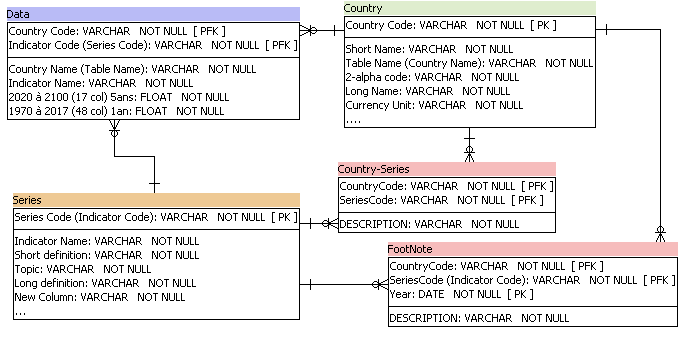

In [100]:
Image("../UML/EduStatsMPD.png")

Les clés proposées dans le MPD ci-dessus pour chaque jeu faciliteraient l'utilisation de la base, sous réserve de quelques modifications (voir modifications plus bas) :
- renommer certaines colonnes afin de lever les ambiguïtés
(ex : Series/"Series Code" -> Series/"Indicator Code")
- supprimer les colonnes redondantes ou inutiles
(ex : Data/"Country Name", accessibles via la clé étrangère "Country Code" en colonne Country/"Table Name")

### 1.1 Données manquantes
#### Comptage des données manquantes

In [119]:
# nbe de remplissage minimum/maximum et année correspondante
sel_data = inf_data.loc["count"][4:]
val_min = sel_data.min()
val_max = sel_data.max()

print("- année nbe entrées min, nbe entrées min : \n{}, \n{:.0f}, soit {:.3f}%"\
      .format(sel_data.index[sel_data==val_min], \
              val_min, val_min*100/(data.shape[0])))

print("- année nbe entrées max, nbe entrées max : \n{}, \n{:.0f}, soit {:.3f}%"\
     .format(sel_data.index[sel_data==val_max], \
             val_max, val_max*100/(data.shape[0])))

- année nbe entrées min, nbe entrées min : 
Index(['2017'], dtype='object'), 
143, soit 0.016%
- année nbe entrées max, nbe entrées max : 
Index(['2010'], dtype='object'), 
242442, soit 27.335%


- La table "Data" donnant la valeur d'un indicateur pour une année comporte environ 86 % de données non renseignées.
- Environ 60% de l'ensemble des couples Indicateur/Pays n'a aucune valeur renseignée.
- L'année la mieux renseignée est l'année 2010 (27% des couples Indicateur/Pays, soit plus de 242 000 valeurs), et les moins renseignées sont les années 2016 et 2017 (respectivement 1,8% et 0,016% des couples, soit 16460 et 143 valeurs)

#### Table "Data"

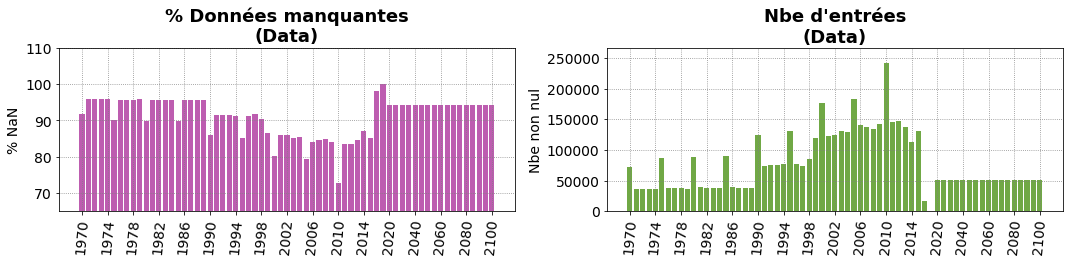

In [159]:
fig = plt.figure(figsize = (18,3))

x=inf_data.columns[4:]
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_data[inf_data.columns[4:]].loc["null"]*100/data.shape[0] # % de valeurs nulles
y2=inf_data[inf_data.columns[4:]].loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab[::4], "", "% NaN",  "% Données manquantes\n(Data)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab[::4], "", "Nbe non nul",  "Nbe d'entrées\n(Data)", 1)

plt.show()

#### Table "Country"

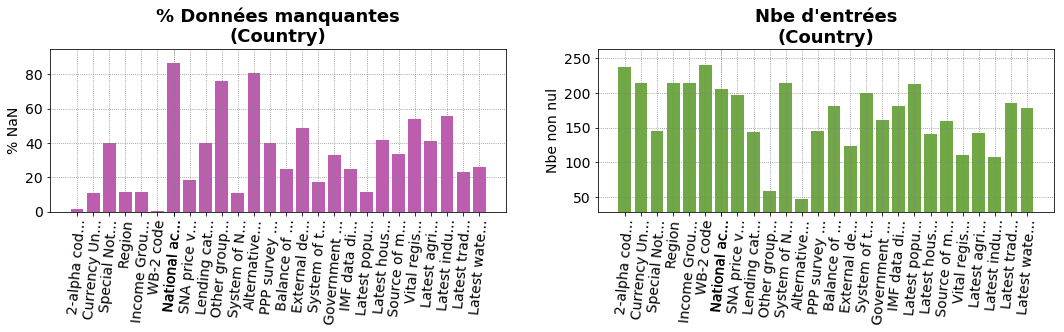

In [161]:
fig = plt.figure(figsize = (18,3))

x=inf_country.columns[4:]
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_country[inf_country.columns[4:]].loc["null"]*100/country.shape[0]  # % de valeurs nulles
y2=inf_country[inf_country.columns[4:]].loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Country)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Country)", 1)

plt.show()

#### Table "Series"

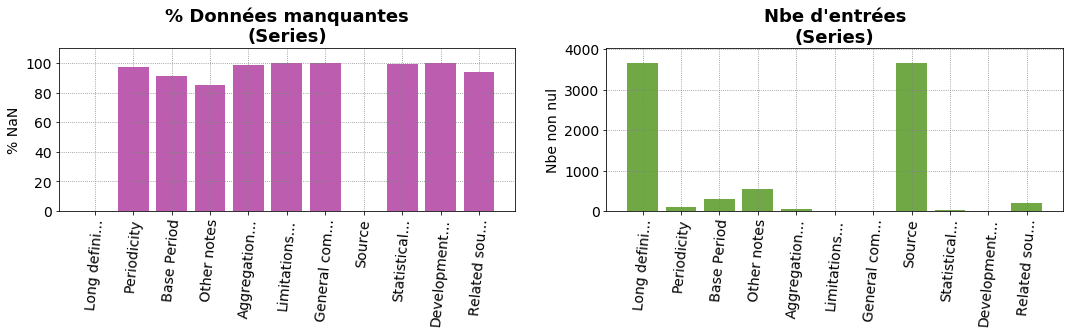

In [162]:
fig = plt.figure(figsize = (18,3))

x=inf_series.columns[4:]
xlab=[my_str[:11]+"..." if len(my_str)>11 else my_str for my_str in x]
y1=inf_series[inf_series.columns[4:]].loc["null"]*100/series.shape[0]  # % de valeurs nulles
y2=inf_series[inf_series.columns[4:]].loc["count"] # nombre de valeurs

plot1 = plt.subplot(1,2,1)
basic_plot("bar", plot1, xlab, y1, xlab, "", "% NaN",  "% Données manquantes\n(Series)", 0)

plot2 = plt.subplot(1,2,2)
basic_plot("bar", plot2, xlab, y2, xlab, "", "Nbe non nul",  "Nbe d'entrées\n(Series)", 1)

plt.show()

#### Tables "Country-Series" et "FootNote"

In [165]:
print("la table 'CountrySeries' contient {} entrées nulles".format(inf_cnt_ser.loc["null"].sum()))
print("la table 'FootNote' contient {} entrées nulles".format(inf_footnote.loc["null"].sum()))

la table 'CountrySeries' contient 0 entrées nulles
la table 'FootNote' contient 0 entrées nulles


#### Elimination des lignes et colonnes sous-remplies

### 1.2 Données dupliquées ou contradictoires

#### Vérification de l'unicité des clés de chaque table

La description ci-dessus nous a permis de déterminer les colonnes de chaque bases susceptibles de jouer le rôle de clés. Afin de faciliter l'exploitation de la base, il est important que la clé de chaque table soit unique.
Vérifions donc que les tables sont exemptes de doublons :

In [ ]:
# Fonction vérifiant l'unicité des lignes d'une liste de listes
def uniCle (t_tab): 
    if isinstance(t_tab[0], type(str)) :
        uni = list(set(t_tab))
        res = True if (len(uni)==len(t_tab)) else False
    else :
        uni = list(set(zip(*t_tab))) # liste des combinaisons uniques
        res = True if (len(uni)==len(t_tab[0])) else False
    return res

In [ ]:
######## A VERIFIER
print("Table Data : Unicité de la clé ('Country Code'&'Indicator Code') {}"\
      .format(uniCle([data["Country Code"], data["Indicator Code"]])))
print("Table Country : Unicité de la clé ('Country Code') {}"\
      .format(uniCle(country["Country Code"])))
print("Table Series : Unicité de la clé ('Series Code') {}"\
      .format(uniCle(series["Series Code"])))
print("Table Country-Series : Unicité de la clé ('CountryCode'&'SeriesCode') {}"\
      .format(uniCle([cnt_ser["CountryCode"], cnt_ser["SeriesCode"]])))
print("Table FootNote : Unicité de la clé ('CountryCode'&'SeriesCode'&'Year') {}"\
      .format(uniCle([footnote["CountryCode"],footnote["SeriesCode"],footnote["Year"]])))

Les tables sont bien exemptes de doublons. Pour plus de clarté, on renomme les colonnes contenant des entrées apparentées :

In [ ]:
country_c.rename(columns={'Table Name':'Country Name'}, inplace=True)
series_c.rename(columns={'Series Code':'Indicator Code'}, inplace=True)
cnt_ser_c.rename(columns={'Country Code':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Description'}, inplace=True)
footnote_c.rename(columns={'Country Code':'Country Code',
                          'SeriesCode':'Indicator Code',
                         'DESCRIPTION':'Description'}, inplace=True)

#### Correspondance des entrées uniques des colonnes apparentées

- Les tables "Data" et "Country" n'ont pas le même nombre d'entrée uniques pour la colonne "Country Code" (voir dataframes inf_data et inf_country) : la table "Country" contient un pays en moins. On cherche à déterminer ce pays :

In [ ]:
# Fonction qui trouve les éléments différents dans deux tableaux (réciproque)
# compare puis donne les entrées spécifiques à tab1, puis à tab2
def Diff(tab1, tab2): 
    tab_dif = [i for i in tab1 + tab2 if i not in tab1 or i not in tab2] 
    return (set(tab1)-set(tab2),set(tab2)-set(tab1))

In [ ]:
cnt_lack = Diff(list(data["Country Code"].unique()),list(country["Country Code"].unique()))
print("Codes des pays spécifiques à 'Data' : {}"\
  .format(cnt_lack[0]))
print("Codes des pays spécifiques à 'Country' : {}"\
  .format(cnt_lack[1]))
nom_vgb = list(data[data["Country Code"]=='VGB']["Country Name"].unique())
print("Nom du pays à ajouter : {}".format(nom_vgb))

La table Country étant supposée renseigner sur tous les pays présents dans la base, on rajoute une ligne dans la base "Country" contenant le pays manquant :

In [ ]:
###### A CORRIGER #######
nom_vgb = list(data[data["Country Code"]=='VGB']["Country Name"].unique())
#print("Noms du pays de code 'VGB' : {}".format(nom_vgb))
print(country_c.shape)
line = pd.DataFrame([['VGB',nom_vgb[0]]], columns = ["Country Code", "Country Name"])
#country_c.append(, sort = True)
country_c = country_c.sort_values("Country Code")
#country_c[country_c["Country Code"]=='VGB']
country_c.iloc[231]

- Les tables "Data" et "Series" ont bien le même nombre d'entrée uniques pour la colonne "Indicator Code" et "Series Code" (voir dataframes inf_data et inf_country) : 3665. Vérifions  que ces entrées uniques son bien les mêmes :

In [ ]:
serie_lack = Diff(list(data["Indicator Code"].unique()),list(series["Series Code"].unique()))

print("Nbe d'indicateurs spécifiques à 'Data' : {}"\
  .format(len(serie_lack[0])))
print("Nbe d'indicateurs spécifiques à 'Series' : {}"\
  .format(len(serie_lack[1])))
print("Quelques indicateurs spécifiques à 'Data' :\n {}"\
  .format(sorted(serie_lack[0])[:5]))
print("Quelques indicateurs spécifiques à 'Series' :\n {}"\
  .format(sorted(serie_lack[1])[:5]))

L'échantillon d'indicateurs affichés ci-dessus ne diffèrent en fait que par 1) des espaces 2) des lettres en minuscule dans la table "Series". Vérifions qu'après correction les entrées sont les mêmes :

In [ ]:
test_ser = pd.Series([series["Series Code"][i].upper().replace(" ", "")\
                for i in range(series["Series Code"].index.size)],\
                 index = series["Series Code"].index)
test_data = pd.Series([data["Indicator Code"][i].upper().replace(" ", "")\
                for i in range(data["Indicator Code"].index.size)],\
                 index = data["Indicator Code"].index)
lack1 = Diff(list(data["Indicator Code"].unique()),list(test_ser.unique()))
lack2 = Diff(list(test_data.unique()), list(series["Series Code"].unique()))
lack3 = Diff(list(test_data.unique()), list(test_ser.unique()))

print("-----Correction de 'Series' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack1[0]), len(lack1[1])))
print("-----Correction de 'Data' seule :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack2[0]), len(lack2[1])))
print("-----Correction de 'Data' et 'Series' :-----")
print("Nbe d'indicateurs spécifiques à 'Data', puis 'Series' : {}, {}"\
  .format(len(lack3[0]), len(lack3[1])))

Remarque : La correction des noms des deux bases était nécessaire.

- Vérifions que les pays et les indicateurs présents dans les tables "Country-Series" et "Footnote" sont bien dans la liste des indicateurs de la table "Series" et dans la liste des pays de la table "Country" :

In [ ]:
cnt_ser_lack1 = Diff(list(series["Series Code"].unique()),list(cnt_ser["SeriesCode"].unique()))
cnt_ser_lack2 = Diff(list(country["Country Code"].unique()),list(cnt_ser["CountryCode"].unique()))
footnote_lack1 = Diff(list(series["Series Code"].unique()),list(footnote["SeriesCode"].unique()))
footnote_lack2 = Diff(list(country["Country Code"].unique()),list(footnote["CountryCode"].unique()))

print("-------- table 'CountrySeries' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(cnt_ser_lack1[0]), len(cnt_ser_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'Country-Series' : {}/{}"\
  .format(len(cnt_ser_lack1[1]), len(cnt_ser_lack2[1])))
print("-------- table 'FootNote' --------")
print("Nbe d'indicateurs/de pays spécifiques à 'Series'/'Country' : {}/{}"\
  .format(len(footnote_lack1[0]), len(footnote_lack2[0])))
print("Nbe d'indicateurs/de pays spécifiques à 'FootNote' : {}/{}"\
  .format(len(footnote_lack1[1]), len(footnote_lack2[1])))

In [ ]:
###### PBE A GERER DE NON CONCORDANCE

#### Simplification de la base

- On souhaite ensuie tester la correspondance bijective entre plusieurs paires de colonnes d'une même table afin de pouvoir répondre à des questions du type :

> __Une entrée de 'nom_col1' correspond-elle à une et une seule entrée de la colonne 'nom_col2' dans la table 'df' ?__

On crée une fonction pour cela :

In [ ]:
# Fonction comparant la correspondance unique entre les valeurs d'une même ligne de deux colonnes d'une base
# (bijection entre les valeurs de col1 et de col2)

def Adeq (df, nom_col1,nom_col2):
    mon_zip = zip(df[nom_col1], df[nom_col2]) # associe les entrées des deux colonnes en tuples
    nbe_comb = len(set(mon_zip)) # retourne les valeurs uniques des tuples
    return nbe_comb==df[nom_col1].unique().size # si le nbe est le même que les valeurs uniques, c'est bon

# Version très lourde de la même fonction
# def Adeq_Col(df, nom_col1,nom_col2): # dans une même base df
#     tab = []
#     for i in range(len(df[nom_col1].unique())):
#         uni_i = df[nom_col1].unique()[i]
#         # liste des valeurs de col2 correspondant à la ième valeur unique de col1
#         li = df[df[nom_col1]==uni_i][nom_col2]
#         temp = 0
#         for j in range(len(li)): # comparaison de toutes les valeurs de li une à une
#             if li.iloc[j] != li.iloc[0]: # on prend la première valeur (0) comme référence
#                 temp+=1
#         tab.append(temp)
#     return temp # la valeur retournée est le nombre de valeurs différentes

Puis on teste les couples de colonnes listés ci-dessous :
- Table "Data" : "Country Code", "Country Name"
- Table "Data" : "Indicator Code", "Indicator Name"
- Table "Country" : "Country Code", "Short Name"
- Table "Country" : "Country Code", "Table Name"
- Table "Country" : "Country Code", "Long Name"
- Table "Series" : "Series Code", "Indicator Name"

In [ ]:
print("Data : {} {}"\
      .format(Adeq(data, "Country Code", "Country Name"), Adeq(data, "Indicator Code", "Indicator Name")))
print("Country : {} {} {}"\
      .format(Adeq(country, "Country Code", "Short Name"), Adeq(country, "Country Code", "Table Name"),\
        Adeq(country, "Country Code", "Long Name")))
print("Series : {}".format(Adeq(series, "Series Code", "Indicator Name")))

Y a-t-il la même correspondance entre les codes pays ("Country Code") et les noms de pays dans les tables "Data" ("Country Name") et "Country" ("Table Name") ?
Si oui, on ne gardera qu'une des deux colonnes.

In [ ]:
#set(zip(sorted(data["Country Name"].unique()), sorted(country["Table Name"].unique())))
data_gb_cnt = data.groupby("Country Code").count() #"Country Name"

In [ ]:
indic = Diff_bis(list(data["Indicator Name"].unique()),list(series["Indicator Name"].unique()))
len(indic[0]), len(indic[1])

On remarque que 462 entrées uniques de la colonne "Indicator Name" de la table "data" ne sont pas dans la table "series" et que le même nombre 462 d'entrées uniques de la même colonne de la table "series" ne sont pas dans la table "data".

Cela pourrait-il indiquer qu'il s'agirait des mêmes entrées qui ne présentent que de petites variations d'écriture, comme c'est le cas pour les deux entrées ci-dessous ?

In [ ]:
a = data["Indicator Code"][data["Indicator Name"]=='SABER: (School Autonomy Accountability) Policy Goal 2: Level of autonomy in personnel management'].iloc[0:3]
b = series["Series Code"][series["Indicator Name"]=='SABER: (School Autonomy and Accountability) Policy Goal 2: Level of autonomy in personnel management']
a,b

Les années de la table "FootNote" sont-elles dans les années correspondant aux noms de colonnes de la table "Data" ?

In [ ]:
# liste des années de la colonne "Year" de la table "FootNote"
#set(footnote["Year"].unique())
footnote[footnote["Year"]=='yr2012']

## 2. Exploration des données

Les indicateurs qui nous intéressent sont ceux des dernières années.
On cherche à savoir :
- combien d'indicateurs environ sont disponibles dans les dernières années
- quels sont les pays qui ont le plus d'indicateurs disponibles dans les dernières années
- quels sont les indicateurs le plus souvent disponible 

### Nombres d'indicateurs disponibles selon les années

In [ ]:
# Tableau des nombres d'indicateurs dispo pour chaque pays et chaque année 
nb_ind_cnt = data.groupby(['Country Name', 'Country Code']).count()

In [ ]:
# Pays ayant un nbe d'indicateur non nul en 2017
nb_ind_cnt[nb_ind_cnt['2017']!=0]

In [ ]:
# Nbe de pays ayant un nbe d'indicateur supérieur à n en fonction des années

def calc_nb_pay_rens (tab_n):
    tab = [ [nb_ind_cnt[nb_ind_cnt[str(i)]>j].index.size for i in years] for j in tab_n ]
    res = np.array(tab).T
    return res

countrys = [nb_ind_cnt.index[i][0] + " - " + nb_ind_cnt.index[i][1] for i in range(nb_ind_cnt.index.size)]
years = list(range(1970,2018))+list(range(2020,2105,5))
tab_n = [0,2,10,50,100, 200, 500]
x = years
y = calc_nb_pay_rens(tab_n)
len(y[:, 1]), len(x)

In [ ]:
### FAIRE UNE HEATMAPP DU NBE D'INDICATEURS (PAYS/ANNEES)
fig = plt.figure(figsize = (18,6))

colors = ["#bd5db0","#70a845","#727bcc","#b49242","#cc566c","#4aad92","#ca6037"]
labels = ["i="+str(i) for i in tab_n]

plot1 = plt.subplot(1,2,1)
[plot1.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot1.set_ylim(0,250)
plot1.legend(loc = 'lower right')
plot1.set_xlabel("années", fontsize = 14)
plot1.set_ylabel("nbe de pays", fontsize = 14)
plot1.set_title("Pays ayant plus de i indicateurs", fontsize = 18, fontweight = 'bold')

plot2 = plt.subplot(1,2,2)
[plot2.plot(x, y[:,i], '-o', label = labels[i], color = colors[i]) for i in range(len(tab_n))]
plot2.set_xlim(1980,2018)
plot2.set_ylim(75,250)
plot2.legend(loc = 'lower right')
plot2.set_xlabel("années", fontsize = 14)
plot2.set_ylabel("nbe de pays", fontsize = 14)
plot2.set_title("Pays ayant plus de i indicateurs (zoom)", fontsize = 18, fontweight = 'bold')
plt.show() 

- Tous les pays ont au moins 1 indicateur
- 167 pays ont des projections d'indicateurs (entre 200 et 500)
- les données sont très rares pour l'année 2018 (7 indicateurs pour la grande majorité des pays

### Exploration des mots clés dans les noms d'indicateurs

In [ ]:
def contAny (cars, mot):
    return any([True if c in cars else False for c in mot])

def contAll (cars, mot):
    return all([True if c in cars else False for c in mot])

def enum_mots_cmpt(li_phrases, nb): # prend une liste de phrases en entrée
    li_mots = " ".join(li_phrases).split(" ")
    li_mots_net = sorted([mot for mot in li_mots if (mot != '') \
                          and not contAll('-)%.(,', mot)])
    cpt = Counter(li_mots_net)
    words_occ = cpt.most_common(nb) # tableau de tuples
    words = [words_occ[i][0] for i in range(len(words_occ))]  
    occs = [words_occ[i][1] for i in range(len(words_occ))]
    dic_occs = dict() 
    for i in range(len(words_occ)):
        dic_occs[words[i]]=occs[i]
    return dic_occs # dictionnaire

def filt_dict(dic_t, li_pop):
    dic = dic_t
    [dic.pop(w) for w in li_pop if w in dic_t.keys()]
    return dic

In [ ]:
def random_color_func(word=None, font_size=None, position=None, orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(np.random.randint(70, 120) / 255.0))
    return "hsl({}, {}%, {}%)".format(h, s, l)
tone = 10.0 # define the color of the words

def nuageMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,8))
    wordcloud = WordCloud(width=1000,height=200, background_color='black', max_words=1628,\
                      relative_scaling=1, color_func = None, normalize_plurals=False)
    wordcloud.generate_from_frequencies(dic_occs)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
def histMots(dic_occs): # prend un dictionnaire {"mot" : nbe occurences}
    fig = plt.figure(figsize=(18,4))
    tab_occs = np.array([[k,int(v)] for k,v in dic_occs.items()]).T   # dictionnaire en tableau
    x = tab_occs[0]
    y = tab_occs[1].astype(int)
    x_label = tab_occs[0]
    ax = plt.bar(x, y, align = 'center', color='b')
    plt.xticks(x, x_label, rotation=85, fontsize = 15)
    plt.yticks(fontsize = 15)
    plt.ylabel("Nb. of occurences", fontsize = 18, labelpad = 10)
    plt.title("Fréquence des mots-clés",color='k',fontsize = 18, fontweight = 'bold')
    plt.show() # affiche l'histogramme

In [ ]:
list_pop = ["in", "of", "a", "and", "Per", "by", "the", "with", "to", "from",\
            "for", "who", "on", "are"] # liste des mots non considérés

# génération dictionnaire effectif mots-clés 
dic_occs = enum_mots_cmpt(data["Indicator Name"], 30) # à parti des noms d'indicateurs dans "Data"
dic_occs = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables
dic_occs2 = enum_mots_cmpt(data["Country Name"], 30) # à partir des indicateurs uniques
dic_occs2 = filt_dict(dic_occs,list_pop) # filtrage des mots indésirables

nuageMots(dic_occs), nuageMots(dic_occs2)

In [ ]:
histMots(dic_occs), histMots(dic_occs2)

PBE A REGLER : les deux graphes sortent les mêmes résultats !!!!

### Détection des outliers

In [ ]:
# prend un tableau de valeurs, calcule la moyenne, l'écart type
# et renvoie les valeurs au-delà ou en-deça de x fois l'écart type
def detOutliers(df,col,x):
    moy = df[col].mean()
    std = df[col].std()
    out_val = [nb for nb in df[col].values if ((nb<moy-(x*std)) or (nb>moy+(x*std)))]
    return df[df[col].isin(out_val)]

my_tab = [1,3,0,2,5]
df = pd.DataFrame({'my_col' : my_tab})

tab_df = [detOutliers(df, "my_col",x) for x in np.linspace(0,2.5,7)]
[plt.plot(df.index, df["my_col"].values,'o-', label = "x = "+str(df.index.values)) for df in tab_df]
plt.legend()
plt.show()

In [ ]:
fig, (plot1, plot2) = plt.subplots(1, 2, figsize = (25,6), gridspec_kw={'width_ratios': [3, 2]})
x=[1,2,3]
y=[8,7,6]
# plot1.plot(x, y)
# plot2.plot(y, x)

plot1 = plt.subplot(1,2,1)
#data.boxplot(column = list(data.columns[4:52]))
plot1.boxplot(data[data.columns['1970':'2017']])
#plot1.set_ylim(-300,550050)

# plot2 = plt.subplot(1,2,2)
# plot2.boxplot(data_val_0)
# #data[data.columns[52:]].dropna(inplace = False).boxplot(data.columns[52:])
# plot2.set_ylim(-3,20)

plt.show()

## -------------- BROUILLONS -------------

In [ ]:
## groupby, merge, join, concat etc.

#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False,
# right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False, validate=None)
df1 = pd.DataFrame({'lkey': ['foo', 'bar', 'baz', 'foo'], 'value': [1, 2, 3, 1], 'value2': [100, 200, 300, 500]})
df2 = pd.DataFrame({'rkey': ['foo', 'bar', 'baz', 'foo'], 'value': [5, 6, 7, 8]})
#df1.merge(df2, right_on='rkey')
df1.merge(df2, left_on = 'lkey', right_on='rkey')
df1.groupby(['value', 'lkey']).count()

In [ ]:
my_df = data[data["Indicator Code"]=='SP.POP.1524.TO.UN']
my_df.dropna(how = 'all', inplace = True)
x = my_df["Country Name"]
y = my_df["2000"]
# pop de 15 à 24 ans en 2000 selon les pays :
plt.plot(x,y)
plt.show()

In [ ]:
tab1 = [4, 0,1,np.nan,50]
tab2 = [10, 20,30,np.nan,50]
tab3 = [np.nan, np.nan,np.nan,3,np.nan]
df = pd.DataFrame([tab1,tab2,tab3]).rename(index={0:'coucou', 1:'recou', 2:'rerec'})
df["total"] = [10,100,1000]
df